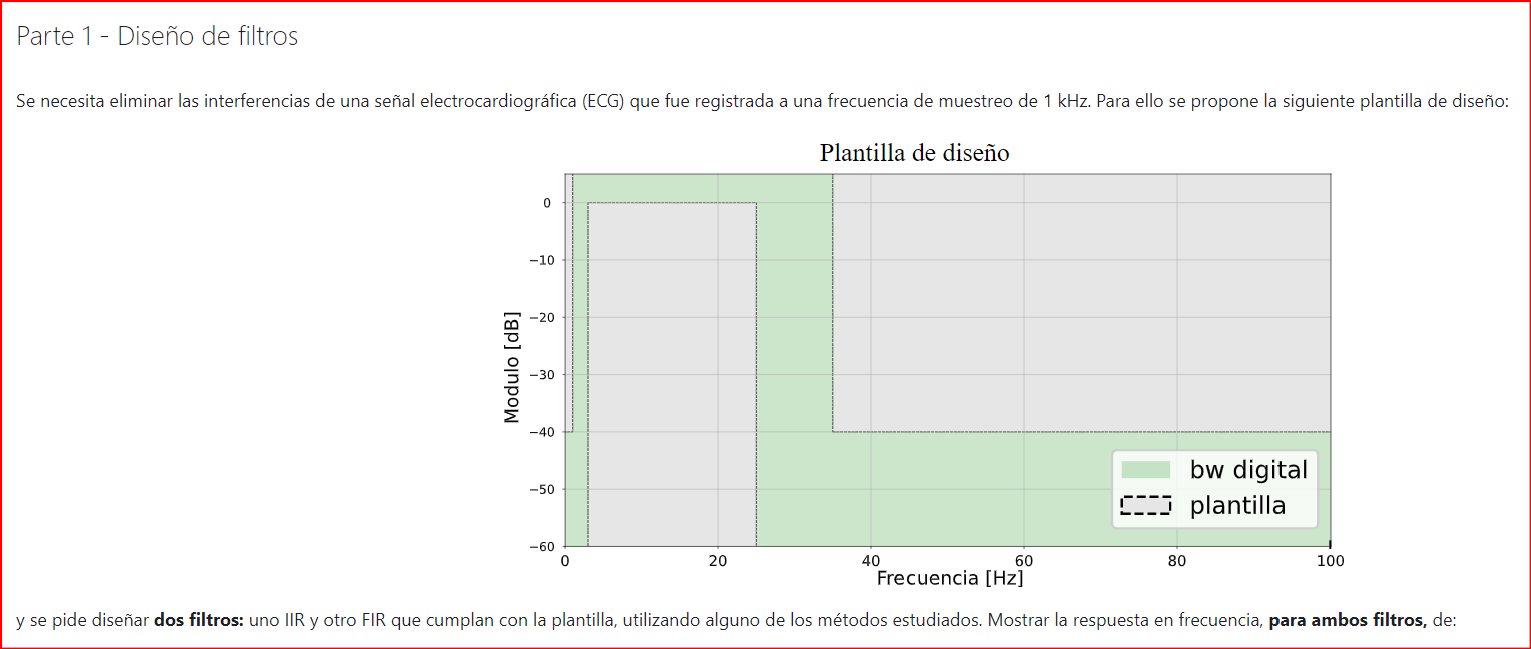

## Filtro IIR

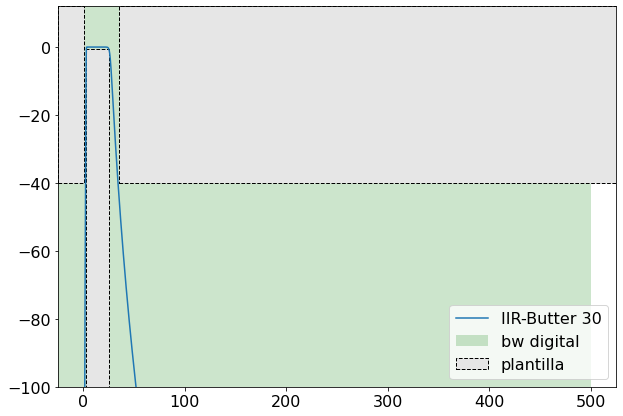

(3,
 <AxesSubplot:title={'center':'Group delay'}, xlabel='Angular frequency [rad/sec]', ylabel='Group Delay [sec]'>)

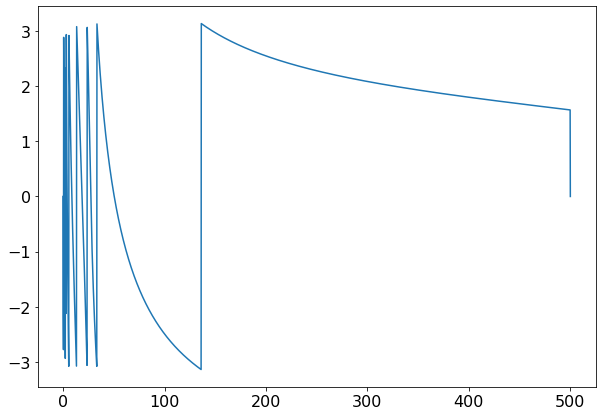

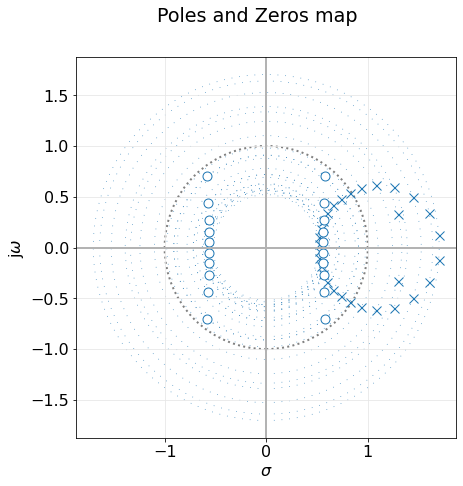

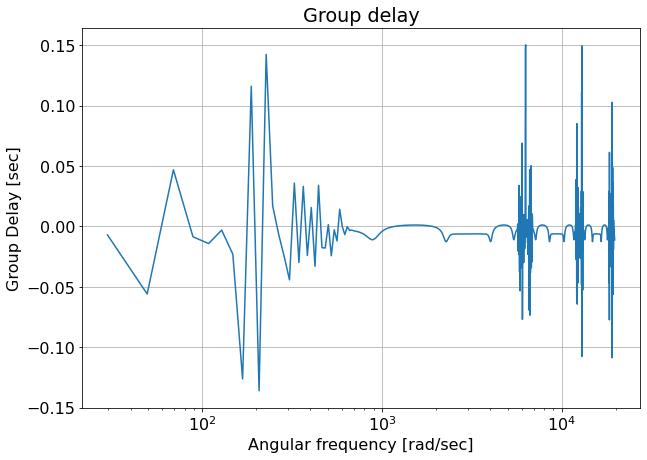

In [46]:
# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from splane import pzmap, GroupDelay, bodePlot, plot_plantilla, analyze_sys
from scipy.signal import TransferFunction
from cmath import phase

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})


fs = 1000 # Hz
nyq_frec = fs / 2

# Plantilla

# filter design
ripple = 0.5 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

bp_sos_butter = sig.iirdesign([frecs[2],frecs[3]],[frecs[1],frecs[4]],ripple,atenuacion,analog=False,ftype='butter',output='sos')

num,den = sig.iirdesign([frecs[2],frecs[3]],[frecs[1],frecs[4]],ripple,atenuacion,analog=False,ftype='butter',output='ba')

#w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
#w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi
w = np.linspace(0,np.pi,2500)

H = sig.sosfreqz(bp_sos_butter,w)

modulo = abs(H[1])

fase = np.array(list(map(phase, H[1])))

w = w / np.pi * nyq_frec
# w = w / np.pi * nyq_frec

plt.figure()

plt.plot(w, 20*np.log10(np.abs(H[1])+1e-12), label='IIR-Butter {:d}'.format(bp_sos_butter.shape[0]*2) )
  

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

plt.plot(w, fase)

my_dig_filter = sig.TransferFunction(num,den,dt = 1/fs) #al indicar dt le decimos a la funcion que la transferencia es en Z

pzmap(my_dig_filter)
GroupDelay(my_dig_filter)

## Filtro FIR

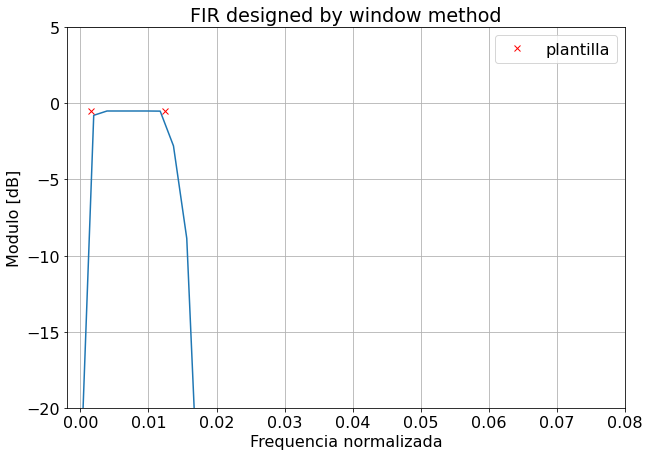

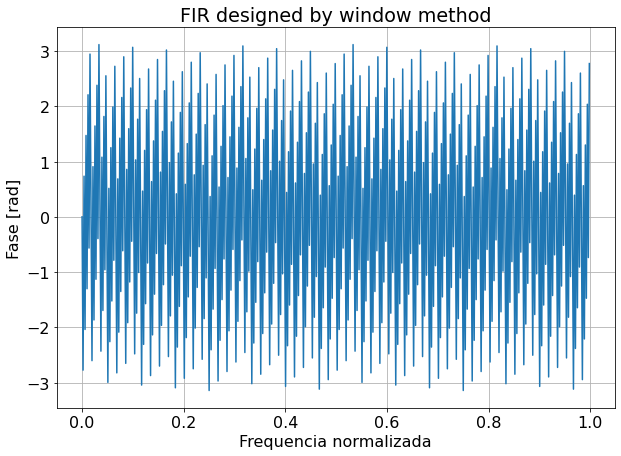

(1,
 <AxesSubplot:title={'center':'Group delay'}, xlabel='Angular frequency [rad/sec]', ylabel='Group Delay [sec]'>)

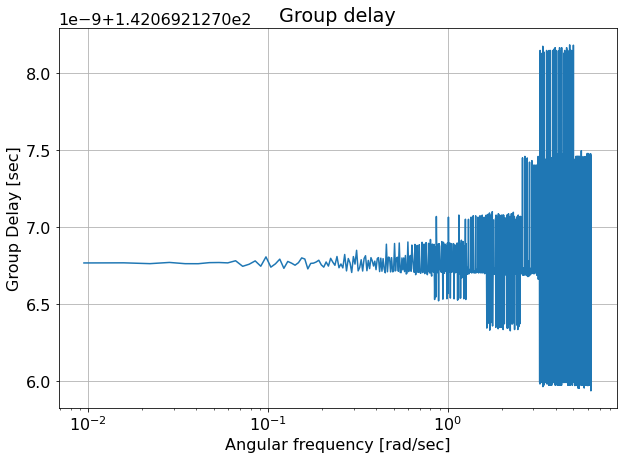

In [47]:
cant_coef = 5001

#####################
## tipos de filtro ##
#####################

if cant_coef % 2 == 0:
    cant_coef += 1 #nos aseguramos de retardo de grupo entero
    
tipo_filtro = 'bp' # pasa banda

# plantilla
ripple = 0.5 # dB
atenuacion = 40 # dB

fs = 1000 # Hz
nyq_frec = fs / 2

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs = [0.0,         ws1/fs/2,     wp1/fs/2, wp2/fs/2,     ws2/fs/2, 1]

gains = [-atenuacion,-atenuacion, -ripple, -ripple, -atenuacion, -atenuacion]
gains = 10**(np.array(gains)/20)
    
fs = 1.0/np.pi

# algunas ventanas para evaluar
#win_name = 'boxcar'
#win_name = 'hamming'
win_name = 'blackmanharris'
#win_name = 'flattop'


# FIR design
num = sig.firwin2(cant_coef, frecs, gains , window=win_name )
den = 1.0


ww, hh = sig.freqz(num, den)
ww = ww / np.pi

fase = np.array(list(map(phase, hh)))


plt.figure()

plt.plot(ww, 20 * np.log10(abs(hh)))


plt.plot(frecs, 20*np.log10(gains), 'rx', label='plantilla' )

plt.title('FIR designed by window method')
plt.xlabel('Frequencia normalizada')
plt.ylabel('Modulo [dB]')
plt.grid(which='both', axis='both')
plt.axis([-1/nyq_frec,40/nyq_frec,-20,5])

axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()
plt.figure()

plt.plot(ww, fase )

plt.title('FIR designed by window method')
plt.xlabel('Frequencia normalizada')
plt.ylabel('Fase [rad]')
plt.grid(which='both', axis='both')
plt.show()

my_dig_filter = sig.TransferFunction(num,den,dt = 1/fs) #al indicar dt le decimos a la funcion que la transferencia es en Z

GroupDelay(my_dig_filter)

# Parte 2

Ahora usaremos ambos filtros para atenuar las interferencias:

In [31]:
ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

# IIR
ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)

# FIR
ECG_f_win = sig.filtfilt(num, den, ecg_one_lead)

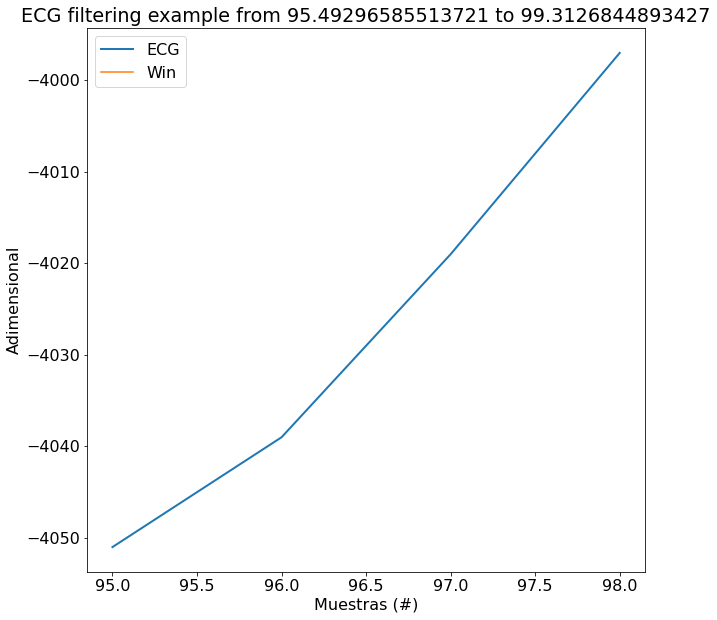

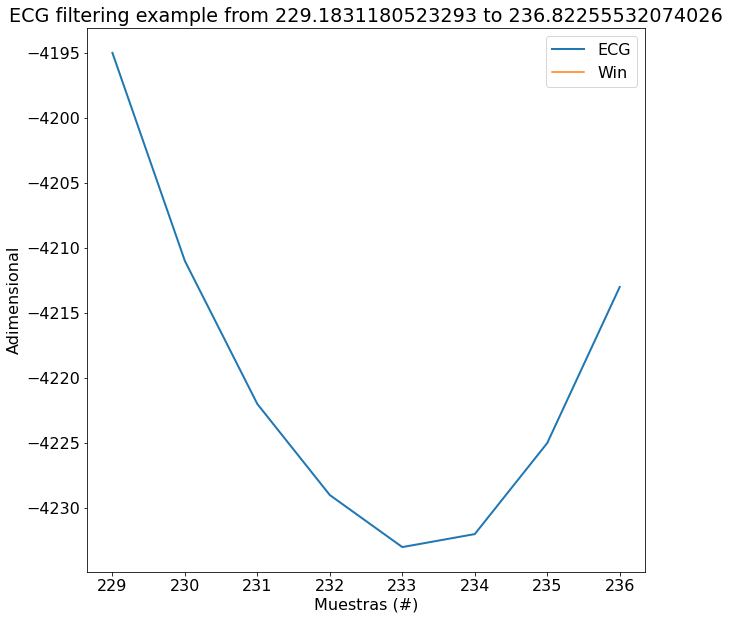

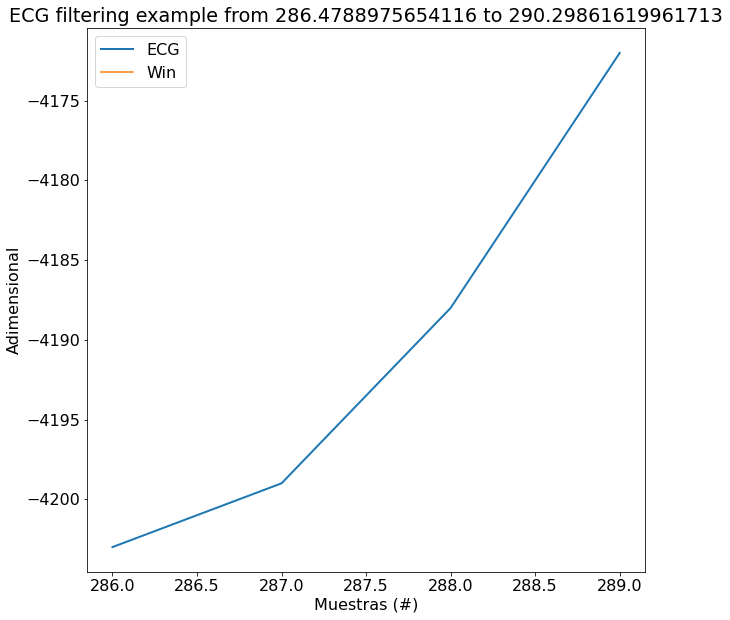

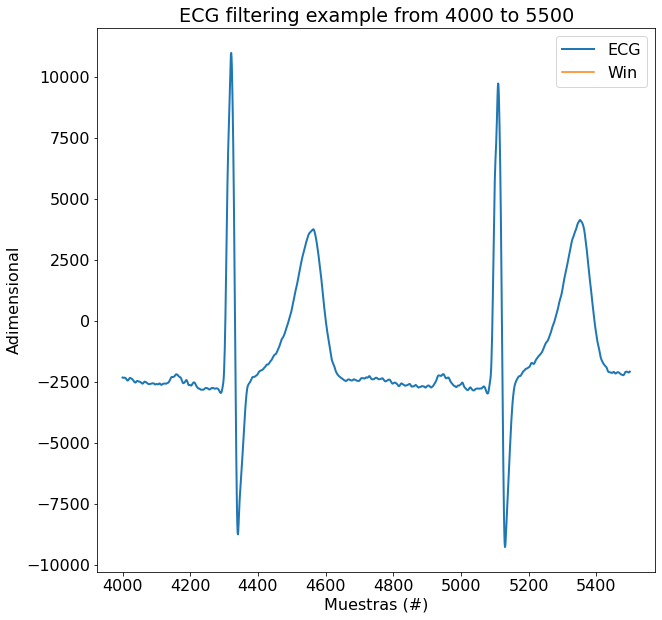

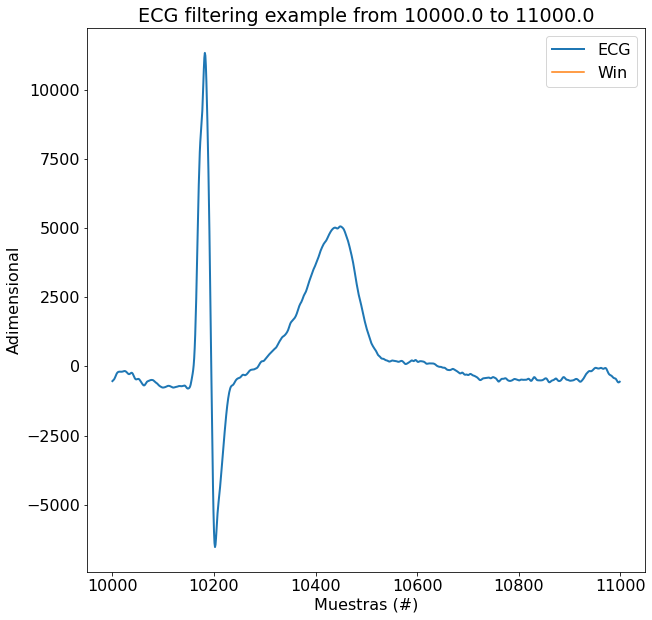

In [45]:
demora = 2500

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region+demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
            
    plt.show()